sift detection

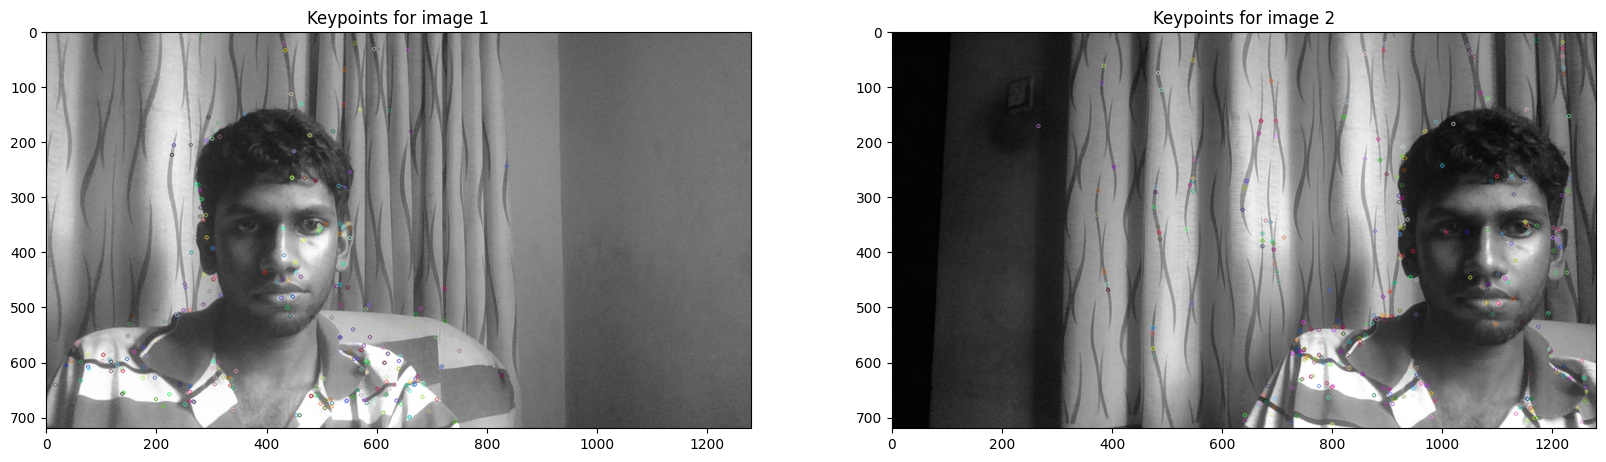

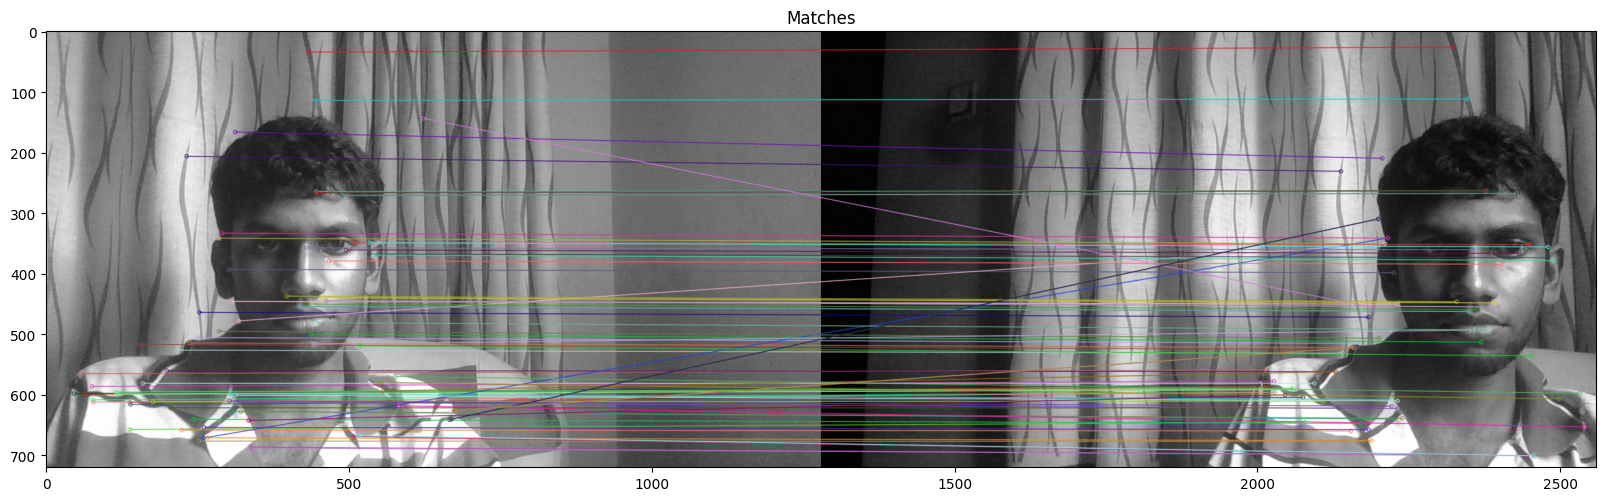

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

im2 = cv.imread('1.jpg')
im1 = cv.imread('2.jpg')

assert im1 is not None
assert im2 is not None

im1_gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
im2_gray = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)

#create a sift object
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.07, edgeThreshold=10, sigma=1)

#detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(im1_gray, None)
kp2, des2 = sift.detectAndCompute(im2_gray, None)

#draw keypoints
im1_kp = cv.drawKeypoints(im1_gray, kp1, None)
im2_kp = cv.drawKeypoints(im2_gray, kp2, None)

#plot images
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(im1_kp)
plt.title('Keypoints for image 1')
plt.subplot(122)
plt.imshow(im2_kp)
plt.title('Keypoints for image 2')
plt.show()

#match keypoints
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

#apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

#draw matches
im_matches = cv.drawMatchesKnn(im1_gray, kp1, im2_gray, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#plot image
plt.figure(figsize=(20,20))
plt.imshow(im_matches)
plt.title('Matches')
plt.show()



In [14]:
import cv2 as cv
import numpy as np
from scipy import linalg

# Load your images 'im1' and 'im2'

# Detect keypoints and compute descriptors for both images using SIFT
sift = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.08, edgeThreshold=8, sigma=1)

kp1, desc1 = sift.detectAndCompute(im1, None)
kp2, desc2 = sift.detectAndCompute(im2, None)

# Create a Brute-Force Matcher and perform keypoint matching
bf = cv.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)
good, pts1, pts2 = [], [], []

# Apply the ratio test to filter good matches and extract corresponding keypoints
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

# Convert lists to NumPy arrays for further processing
good, pts1, pts2 = np.array(good), np.array(pts1), np.array(pts2)

# Draw the good matches
matched_img = cv.drawMatchesKnn(im1, kp1, im2, kp2, good[:50], None, flags=2)

# Define a function to compute the homography matrix
def homography(pts1, pts2):
    # Calculate mean and scaling factors for normalization
    mean1, mean2 = np.mean(pts1, axis=0), np.mean(pts2, axis=0)
    s1, s2 = len(pts1) * np.sqrt(2) / np.sum(np.sqrt(np.sum((pts1 - mean1) ** 2, axis=1))), len(pts1) * np.sqrt(2) / np.sum(np.sqrt(np.sum((pts2 - mean2) ** 2, axis=1)))
    
    # Compute the transformation matrices
    tx1, ty1, tx2, ty2 = -s1 * mean1[0], -s1 * mean1[1], -s2 * mean2[0], -s2 * mean2[1]
    T1, T2 = np.array(((s1, 0, tx1), (0, s1, ty1), (0, 0, 1))), np.array(((s2, 0, tx2), (0, s2, ty2), (0, 0, 1)))
    A = []

    # Construct the matrix A for solving the linear system
    for i in range(len(pts1)):
        X11, X21 = T1 @ np.concatenate((pts1[i], [1])).reshape(3, 1), T2 @ np.concatenate((pts2[i], [1])).reshape(3, 1)
        A.append((-X11[0][0], -X11[1][0], -1, 0, 0, 0, X21[0][0] * X11[0][0], X21[0][0] * X11[1][0], X21[0][0]))
        A.append((0, 0, 0, -X11[0][0], -X11[1][0], -1, X21[1][0] * X11[0][0], X21[1][0] * X11[1][0], X21[1][0]))
    
    A = np.array(A)
    
    # Solve the linear system using SVD
    U, S, V = np.linalg.svd(A, full_matrices=True)
    h = np.reshape(V[-1], (3, 3))
    
    # Normalize the homography matrix and return
    H = linalg.inv(T2) @ h @ T1
    H = (1 / H.item(8)) * H
    
    return H

# Define a function to compute the Euclidean distance between two points after applying the homography
def dist(P1, P2, H):
    p1 = np.array([P1[0], P1[1], 1])
    p2 = np.array([P2[0], P2[1], 1])

    p2_estimate = np.dot(H, p1.T)
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    
    return np.linalg.norm(p2.T - p2_estimate)

# Define a function for RANSAC-based homography estimation
def RANSAC_homography(points1, points2):
    inlier_count, selected_inliers = 0, None
    points = np.hstack((points1, points2))
    
    # Calculate the number of iterations based on the probability of outlier detection
    num_iterations = int(np.log(1 - 0.95) / np.log(1 - (1 - 0.5) ** 4))
    
    for _ in range(num_iterations):
        np.random.shuffle(points)
        pts1, pts1_rem, pts2, pts2_rem = points[:4, :2],  points[4:, :2], points[:4, 2:], points[4:, 2:]
        H = homography(pts1, pts2)
        inliers = [(pts1_rem[i], pts2_rem[i]) for i in range(len(pts1_rem)) if dist(pts1_rem[i], pts2_rem[i], H) < 100]
        
        if len(inliers) > inlier_count:
            inlier_count = len(inliers)
            selected_inliers = np.array(inliers)
    
    # Compute the final homography matrix using the selected inliers
    H = homography(selected_inliers[:, 0], selected_inliers[:, 1])
    
    return H

# Call the RANSAC-based homography estimation function
H = RANSAC_homography(pts1, pts2)

# Print the computed homography matrix
print(H)


[[ 4.01195318e-01 -3.99176853e-02  7.01389735e+02]
 [-2.06434257e-01  7.99685193e-01  9.70665140e+01]
 [-4.53099812e-04 -2.55376445e-05  1.00000000e+00]]


Stitch

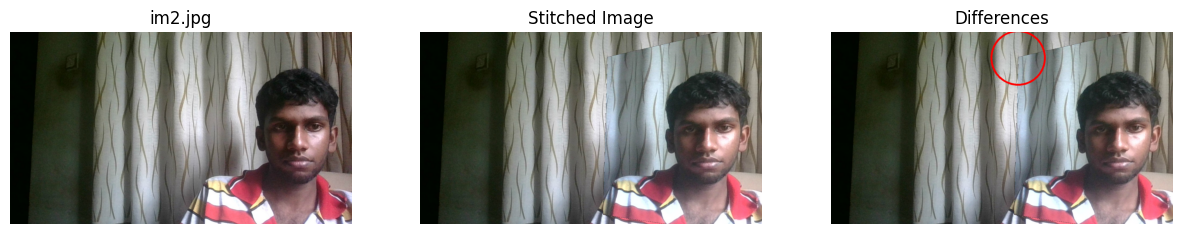

In [15]:
# Convert the list of tuples to a NumPy array
H = np.array(H)

# Warp im1 using the perspective transformation matrix H to match the shape of im2
img_p = cv.warpPerspective(im1, H, (im2.shape[1], im2.shape[0]))

# Threshold the warped image to create a binary mask
# Pixels with values above 10 become 1, and pixels below 10 become 0 (inverted)
ret, threshold = cv.threshold(img_p, 10, 1, cv.THRESH_BINARY_INV)

# Multiply the binary mask with im2 to extract the common region
img2_thresholded = np.multiply(threshold, im2)

# Blend the thresholded image with the warped image
img_blended = cv.addWeighted(img2_thresholded, 1, img_p, 1, 0)

# Create a figure with three subplots for visualization
fig, ax = plt.subplots(1, 3, figsize=(15, 12))

# Display im2
ax[0].imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB))
ax[0].set_title("im2.jpg")
ax[0].axis("off")

# Display the stitched image
ax[1].imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
ax[1].set_title("Stitched Image")
ax[1].axis("off")

# Add a circle to highlight the difference between the images
img_blended = cv.circle(img_blended, (700, 100), 100, (0, 0, 255), 5)

# Display the image with the circle
ax[2].imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
ax[2].set_title("Differences")
ax[2].axis("off")

# Show the figure with the subplots
plt.show()
